# **Univariate statistical analysis**

Author: Filip Ottosson, 
faot@ssi.dk

We will use univariate statistical methods, such as ANOVA, to investigate whether there are differences in the levels of individual features between different time points in the dataset.

**Data**

The files used in this tutorial are part of an interlab comparison study, where different laboratories around the world analysed same environmental samples on their respective LC-MS/MS equipments. To simulate algal bloom, standardized algae extracts (A) in marine dissovled organic matter (M) at different concentrations were prepared (450 (A45M); 150 (A15M); and 50 (A5M) ppm A). Samples were then shipped to different laboratories for untargeted LC-MS/MS metabolomics analysis.

**Task**


*   Are metabolite levels dependent on the diltuion?
*   How does the affected metabolite change throughout the dilution series?
*   How large are the differences? 



**Install and import R packages**


In [ ]:
install.packages("ggsci")
install.packages("matrixStats")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
suppressPackageStartupMessages({library(tidyverse)
library(data.table)
library(ggsci)
library(matrixStats)
library(ggrepel)
})

**Import metabolite feature table and meta data**

In [ ]:
## feature table
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/processed/Imputed_QuantTable_filled_with_MinValue_8115_CutOff_Used_0.3.csv'
## metadata
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/metadata_lab15.txt'

In [ ]:
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [ ]:
dim(ft)
dim(md)

[1] 4641   15

[1] 16  4

In [ ]:
head(ft, n=2)

,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
725_152.071_3.252,8115.00,8115.00,8115.00,75374.20,76915.33,77477.00,73175.08,72739.46,75286.51,59132.38,62091.97,63070.29,54793.090,65684.95,65077.08
1105_152.107_4.734,73926.81,75761.62,79481.29,27020.12,34365.83,30656.02,47937.98,48518.27,53590.48,14726.92,13063.94,20211.17,9119.948,12656.36,10552.45


In [ ]:
head(md, n=2)

,filename,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
,<chr>,<chr>,<chr>,<int>
1,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15
2,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15


In [ ]:
# name rows in metadata after filenames
rownames(md) <- md$filename

In [ ]:
# how many files in the metadata are also present in the feature table
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
    1    15 

In [ ]:
# which file names in the metadata are not in the feature table?
setdiff(rownames(md),colnames(ft))

[1] "DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML"

In [ ]:
md <- md[rownames(md) %in% colnames(ft),]

In [ ]:
dim(md)

[1] 15  4

In [ ]:
# transpose ft
ft <- t(ft)

In [ ]:
dim(ft)

[1]   15 4641

In [ ]:
identical(rownames(ft),rownames(md))
# put the rows in the feature table and metadata in the same order
ft <- ft[match(rownames(md),rownames(ft)),]
identical(rownames(ft),rownames(md))

[1] FALSE

[1] TRUE

Too many missing values is problematic for statistical analyses. Here we calculate the proportion of missing values (coded as 8115) and display the proportions in a histogram

In [ ]:
n_zeroes <- sapply(1:ncol(ft),function(n){sum(ft[,n]==8115)/15})

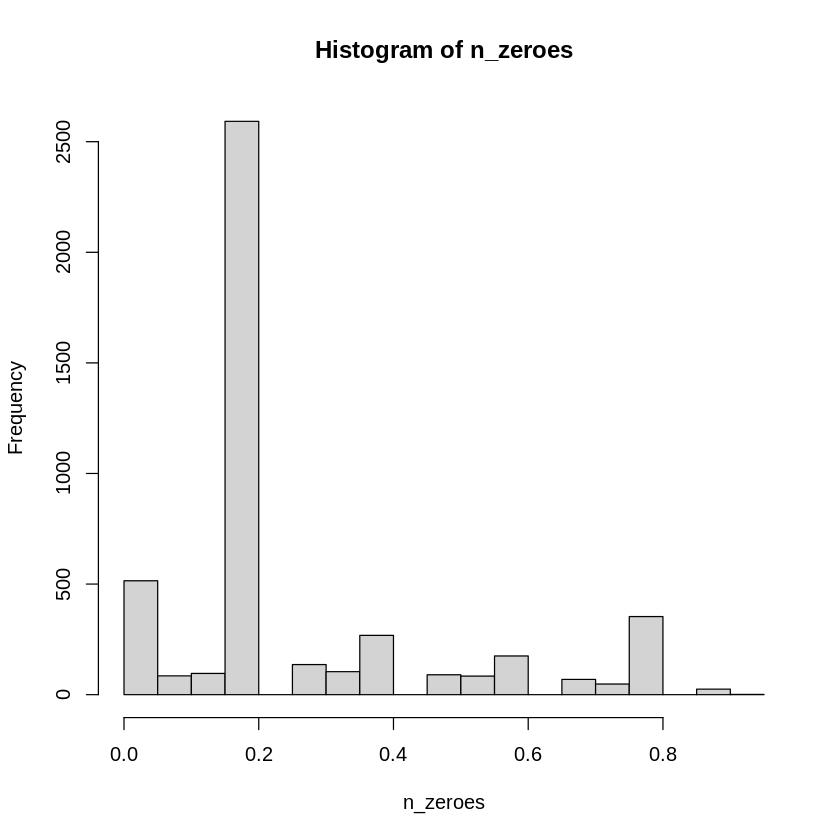

In [ ]:
hist(n_zeroes)

Calculate the sparsity of the dataset (i.e how large proportion of the dataset that consist of missing values)

In [ ]:
sum(ft==8115)/(nrow(ft)*ncol(ft))

[1] 0.2786037

Calculate how many metabolites have measurements (non 8115) in at least 50 % of the samples

In [ ]:
dim(ft[,n_zeroes<0.5])

[1]   15 3886

Deselect metabolites with more than 50 % missing values. This helps to get rid of features that are present in too few samples to conduct proper statistical tests

In [ ]:
ft <- ft[,n_zeroes<0.5]

Merge feature table and metadata to one dataframe

In [ ]:
Data <- cbind.data.frame(md,ft)

**Bring featuretable and metadata in the correct format:**

As the purpose of the experiment is to test whether algal bloom could be monitored using metabolomics, we will remove all samples containing the pure algae extract (A).

In [ ]:
Data <- subset(Data,ATTRIBUTE_Sample!="A")

In [ ]:
dim(Data)

[1]   12 3890

In [ ]:
anova_out=NULL
a <- 5:ncol(Data)
for (i in 1:length(a)){
  anova_out[[i]] <- aov(scale(Data[,a[i]])~as.factor(Data$'ATTRIBUTE_Time-Point'))
}

**Run ANOVA**

We now use the function *aov* to run the ANOVA. Since one ANOVA is being run for each metabolite feature, we run the analyses in a loop and save the output for each feature in a list called *anova_out*

Visualize one entry in the list

In [ ]:
summary(anova_out[[1]])

                                       Df Sum Sq Mean Sq F value  Pr(>F)    
as.factor(Data$"ATTRIBUTE_Time-Point")  3  9.487   3.162   16.73 0.00083 ***
Residuals                               8  1.513   0.189                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

**Extract p- and F-values from anova output list**

Lists of ANOVA results are not convenient when summarizing our findings. We extract the desired data from the list and summarize this in a dataframe called *output_anova*

The following is of interest:

*Feature ID*

*p-value* for ANOVA

*p-value* after taking multiple tests into consideration

*F-value*

In [ ]:
output_anova <- data.frame(colnames(Data[5:ncol(Data)]))
colnames(output_anova)[1] <- "Metabolites"
output_anova["p"] <- sapply(1:length(a),function(n){summary(anova_out[[n]])[[1]][1,5]})
output_anova["p_bonferroni"] <- p.adjust(output_anova$p,method="bonferroni")
output_anova["significant"] <- ifelse(output_anova$p_bonferroni<0.05,"Significant","Nonsignificant")
output_anova["F"] <- sapply(1:length(a),function(n){summary(anova_out[[n]])[[1]][1,4]})

In [ ]:
output_anova %>% arrange (p) %>% slice_head(n=20) #use arrange to sort after p-value and slice_head to show top N columns of data frame

Metabolites,p,p_bonferroni,significant,F
<chr>,<dbl>,<dbl>,<chr>,<dbl>
746_290.123_3.606,1.237189e-15,4.807717e-12,Significant,17805.875
32681_434.293_11.263,2.305162e-15,8.957860e-12,Significant,15239.998
10983_276.134_7,2.858454e-15,1.110795e-11,Significant,14441.852
29693_325.163_10.543,3.475797e-15,1.350695e-11,Significant,13752.690
25135_300.253_9.312,6.285867e-14,2.442688e-10,Significant,6667.477
11281_260.186_7.04,8.502476e-14,3.304062e-10,Significant,6182.320
29295_342.264_10.446,1.370196e-13,5.324582e-10,Significant,5486.761
726_273.145_3.254,2.009078e-13,7.807276e-10,Significant,4985.851
39012_431.283_13.451,2.196852e-13,8.536965e-10,Significant,4875.650


**Plot ANOVA results**

We will use ggplot to visualize results from the ANOVA, with F-values on the x-axis and -log(p) on the y-axis. Features are colored after statistical significance after multiple test correction. 

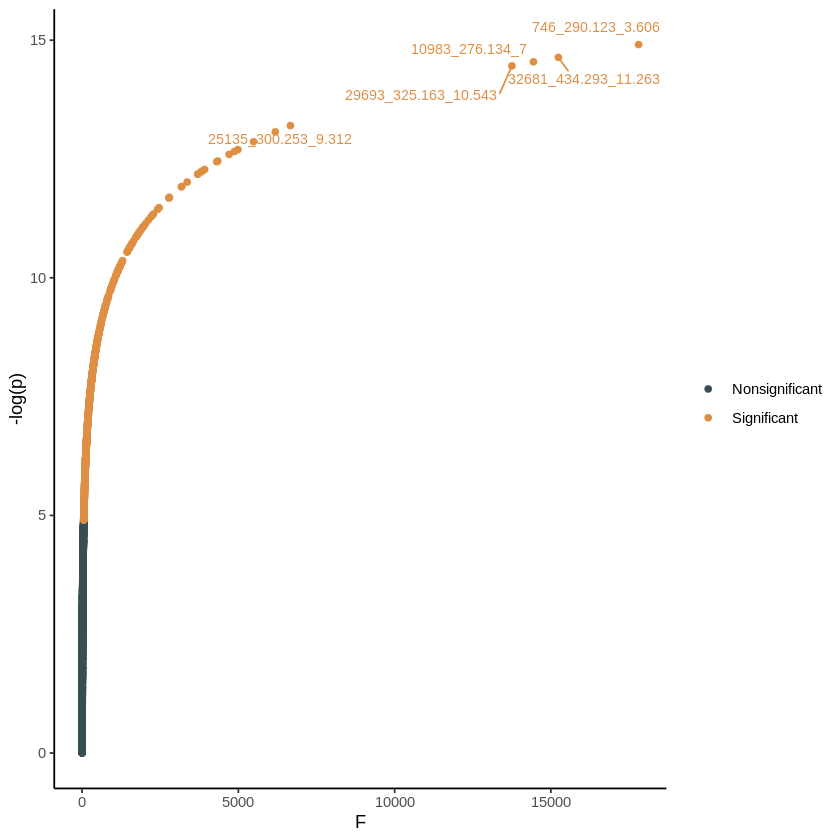

In [ ]:
ggplot(output_anova,aes(x=F,y=-log(p,base=10),color=significant))+ 
geom_point()+
theme_classic()+
scale_color_jama()+
ylab("-log(p)")+
geom_text_repel(data=output_anova %>% arrange(p) %>% slice_head(n=5),
                  aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100)+
theme(legend.title = element_blank())



**Calculate change from baseline and plot dilution series**

Since ANOVA only investigates the difference in variance between and within groups, additional tests are needed to test for differences between individual time points. By selecting features that were significant in the ANOVA, we can plot the temporal trends and select individual time points that we are interested in comparing. 

To simplify, we calculate the median value for each significant feature at each time point. 

In [ ]:
# Calculate medians for each year
timecourse_data <- Data[,4:ncol(Data)] %>% group_by(Data$'ATTRIBUTE_Time-Point') %>% summarize_all(.funs = median) 
# select only metabolites that were significant according to ANOVA
timecourse_data <- timecourse_data[,names(timecourse_data) %in% subset(output_anova,significant=="Significant")$Metabolites]

In [ ]:
# Classify metabolites as increasing or decreasing with time
direction_pos <- sapply(1:ncol(timecourse_data),function(n){ifelse(timecourse_data[1,n]-timecourse_data[4,n]<0,TRUE,FALSE)})
timecourse_pos <- scale(timecourse_data[direction_pos])
timecourse_neg <- scale(timecourse_data[!direction_pos])

In [ ]:
timecourse_neg[1:4,1:4]
dim(timecourse_neg)
timecourse_pos[1:4,1:4]
dim(timecourse_pos)

26713_158.154_9.707,20592_163.039_8.423,29752_163.148_10.547,29763_172.169_10.548
0.05757524,-0.4142495,0.3285386,0.3375216
0.44070260,-0.1689378,0.2590652,0.4026296
0.90808317,1.4382854,0.8577858,0.7367344
-1.40636100,-0.8550980,-1.4453896,-1.4768856


[1]   4 172

1105_152.107_4.734,2431_153.139_5.391,7306_162.055_6.419,37124_163.039_12.677
-0.9012164,-0.6783081,-0.6823672,-0.5751118
-0.6594513,-0.6619828,-0.5594056,-0.5377231
0.2630859,-0.1055759,-0.2307122,-0.3819053
1.2975819,1.4458668,1.4724850,1.4947403


[1]   4 604

Calculate the average for each feature and time point, in order to be able to plot the trends. Error bars can be visualized by calculating the standard deviation at each time point. 

In [ ]:
timecourse_pos_summary <- cbind.data.frame(rep(c(0,5,15,45)),rowMeans(timecourse_pos)-rowMeans(timecourse_pos)[1],
                                   rowMeans(timecourse_pos)-rowMeans(timecourse_pos)[1]+rowSds(as.matrix(timecourse_pos)),
                                   rowMeans(timecourse_pos)-rowMeans(timecourse_pos)[1]-rowSds(as.matrix(timecourse_pos)),
                                   rep("pos",nrow(timecourse_pos)))
colnames(timecourse_pos_summary) <- c("time","median","high","low","direction")

timecourse_neg_summary <- cbind.data.frame(rep(c(0,5,15,45)),rowMeans(timecourse_neg)-rowMeans(timecourse_neg)[1],
                                   rowMeans(timecourse_neg)-rowMeans(timecourse_neg)[1]+rowSds(as.matrix(timecourse_neg)),
                                   rowMeans(timecourse_neg)-rowMeans(timecourse_neg)[1]-rowSds(as.matrix(timecourse_neg)),
                                   rep("neg",nrow(timecourse_neg)))
colnames(timecourse_neg_summary) <- c("time","median","high","low","direction")
# Combine increasing and decreasing features to dataframe for plotting
timecourse_summary <- rbind(timecourse_pos_summary,timecourse_neg_summary)

Plot temporal trends in ggplot

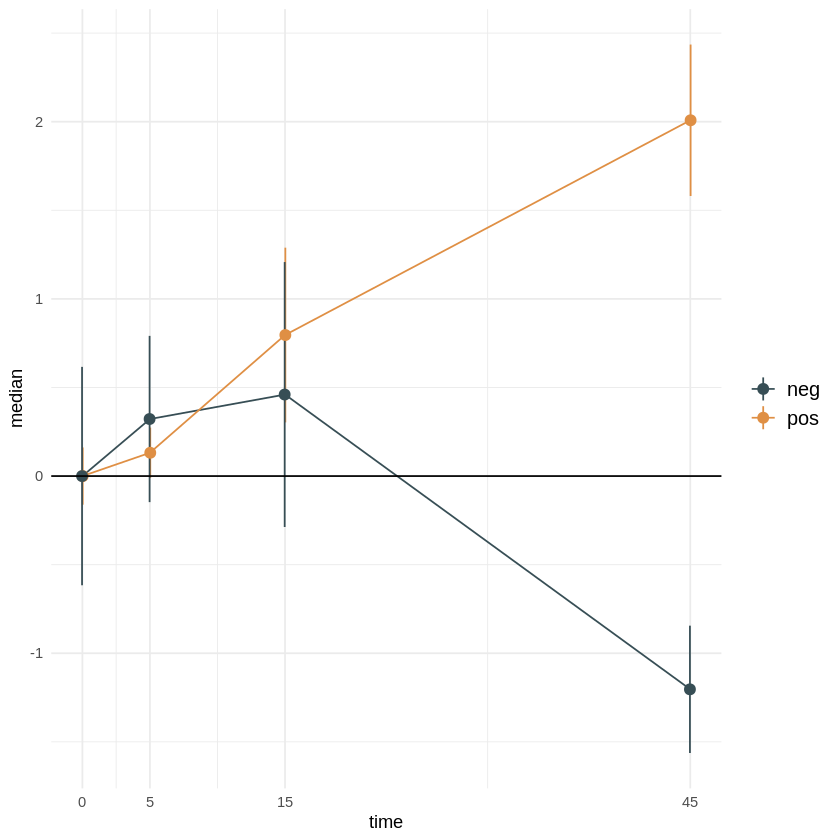

In [ ]:
timecourse_plot <- ggplot(timecourse_summary,aes(x=time,y=median,max=high,min=low,color=direction,fill=direction))+
  geom_line()+
  geom_pointrange(position=position_dodge(0.1))+
  theme_minimal()+
  theme(legend.title = element_blank())+
  geom_hline(aes(yintercept=0))+
  scale_color_jama()+
  scale_fill_jama()+
  scale_x_continuous(breaks=c(0,5,15,45))+
  xlab("time")+
  theme(legend.text=element_text(size=12))

timecourse_plot

In [ ]:
timecourse_neg_summary

time,median,high,low,direction
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0000000,0.6162255,-0.6162255,neg
5,0.3219743,0.7911743,-0.1472256,neg
15,0.4601247,1.2076550,-0.2874057,neg
45,-1.2036485,-0.8443757,-1.5629212,neg


**Tukey's post hoc test**

Features with both positive and negative time trends exist, but differences appear to the largest between timepoint 0 and 45. Tukey's post hoc test can be used to calculate which features show statistically significant differences between these two timepoints. 

The function *TukeyHSD* is used, which calculate these differences from the ANOVA output list previously generated. Results are stored in a new list called *tukey_out*

In [ ]:
tukey_out=NULL
for (i in 1:length(a)){
tukey_out[[i]] <- TukeyHSD(anova_out[[i]])
}

Display first entry of the list to show that all group wise differences are calculated. We are interested in the differences between timepoint 5 and 100.

In [ ]:
tukey_out[[1]]$`as.factor(Data$"ATTRIBUTE_Time-Point")`

,diff,lwr,upr,p adj
5-0,-0.05464772,-1.1915734,1.0822780,0.998588905
15-0,1.91677312,0.7798474,3.0536988,0.002872196
45-0,1.54541934,0.4084936,2.6823450,0.010448798
15-5,1.97142083,0.8344951,3.1083465,0.002402743
45-5,1.60006705,0.4631414,2.7369928,0.008566417
45-15,-0.37135378,-1.5082795,0.7655719,0.729094329


In [ ]:
output_tukey <- data.frame(colnames(Data[5:ncol(Data)]))
colnames(output_tukey)[1] <- "Metabolites"
output_tukey["diff"] <- sapply(1:length(a),function(n){tukey_out[[n]]$`as.factor(Data$"ATTRIBUTE_Time-Point")`[3,1]})
output_tukey["p"] <- sapply(1:length(a),function(n){tukey_out[[n]]$`as.factor(Data$"ATTRIBUTE_Time-Point")`[3,4]})
output_tukey["p_bonferroni"] <- p.adjust(output_tukey$p,method="bonferroni")
output_tukey["significant"] <- ifelse(output_tukey$p_bonferroni<0.05,"Significant","Nonsignificant")

In [ ]:
output_tukey %>% arrange(p) %>% slice_head(n=20)

Metabolites,diff,p,p_bonferroni,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>
11281_260.186_7.04,2.338574,5.162537e-14,2.006162e-10,Significant
726_273.145_3.254,2.360271,5.162537e-14,2.006162e-10,Significant
10983_276.134_7,2.222958,5.162537e-14,2.006162e-10,Significant
746_290.123_3.606,2.413184,5.162537e-14,2.006162e-10,Significant
25135_300.253_9.312,2.385174,5.162537e-14,2.006162e-10,Significant
25522_322.237_9.41,2.404068,5.162537e-14,2.006162e-10,Significant
7406_323.16_6.437,2.417185,5.162537e-14,2.006162e-10,Significant
29693_325.163_10.543,2.308306,5.162537e-14,2.006162e-10,Significant
29295_342.264_10.446,2.350427,5.162537e-14,2.006162e-10,Significant


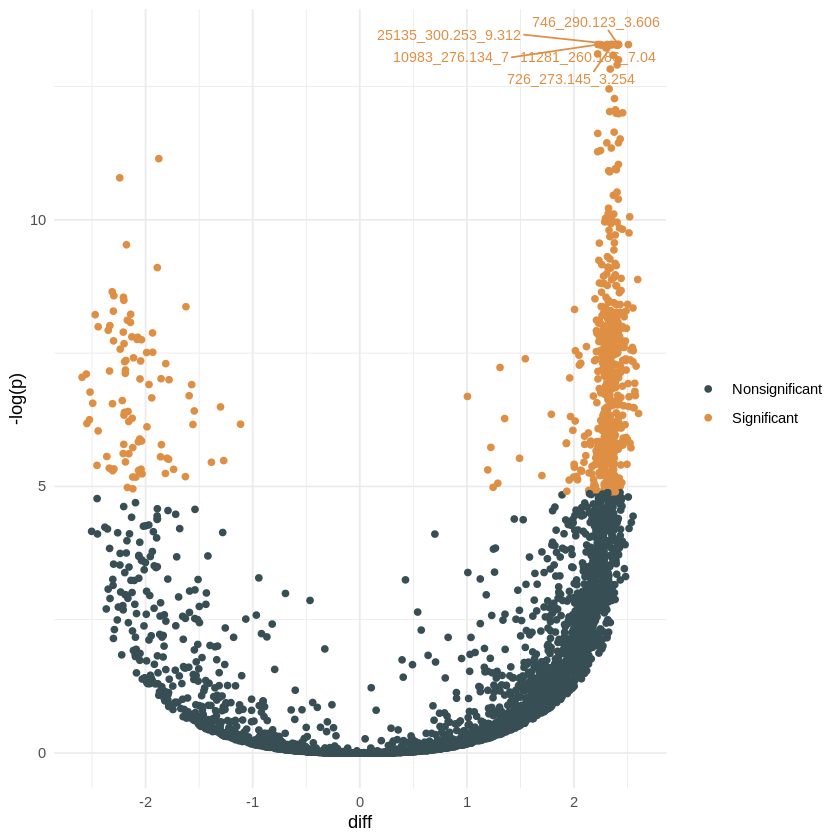

In [ ]:
ggplot(output_tukey,aes(x=diff,y=-log(p,base=10),color=significant))+ 
geom_point()+
theme_minimal()+
scale_color_jama()+
ylab("-log(p)")+
geom_text_repel(data=output_tukey %>% arrange(p) %>% slice_head(n=5),
                  aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100)+
theme(legend.title = element_blank())


Let's look at the feature with largest difference

Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”
Warning message:
“Use of `Data$"11281_260.186_7.04"` is discouraged. Use `11281_260.186_7.04` instead.”
Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”
Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”
Warning message:
“Use of `Data$"11281_260.186_7.04"` is discouraged. Use `11281_260.186_7.04` instead.”
Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”


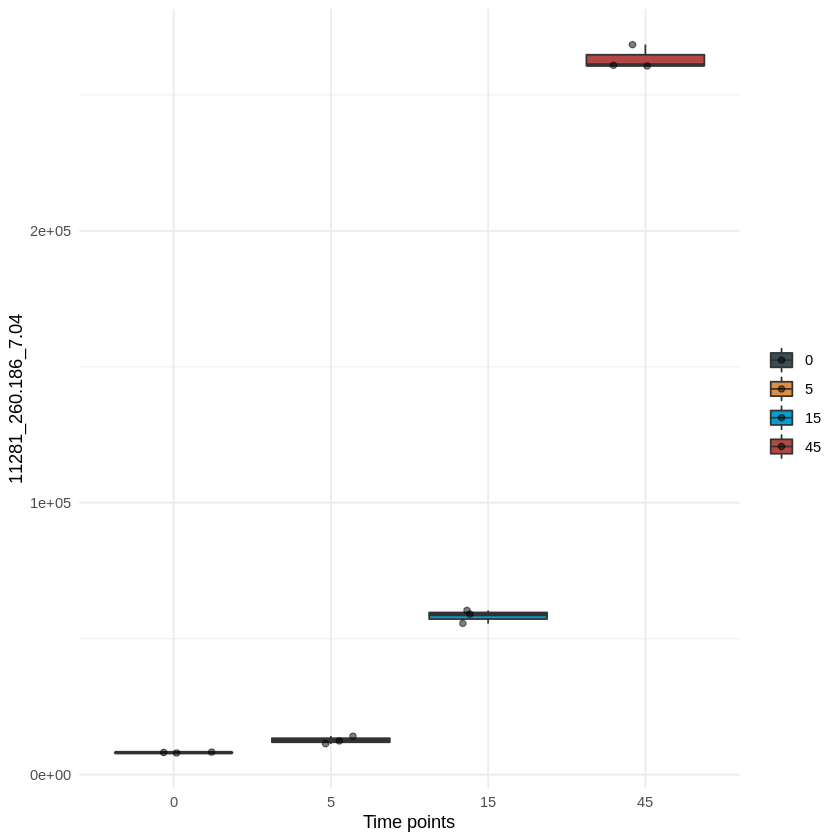

In [ ]:
ggplot(Data,aes(x=as.factor(Data$'ATTRIBUTE_Time-Point'),y=Data$"11281_260.186_7.04",fill=as.factor(Data$'ATTRIBUTE_Time-Point')))+
geom_boxplot()+
geom_jitter(width=0.25, alpha=0.5)+
theme_minimal()+
scale_fill_jama()+
theme(legend.title = element_blank())+
xlab("Time points")+
ylab("11281_260.186_7.04")

In [ ]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrepel_0.9.1      matrixStats_0.62.0 ggsci_2.9          data.table_1.14.2 
 [5] forcats_0.5.1      stringr_1.4.0      dplyr_1.0.9        purrr_0.3.4       
 [9] readr_2.1.2        tidyr_1.2.0        tibble_3.1.7       ggplot2_3.3.6     
[13] tidyverse_1.3.1   

lo